# 1. CREATE MESH USING SMPL MODEL --> POUR GROUPE 2 (Mouvement)
Attention des path vers des repectoire car c'est adapté pour ma machine!

### Definite SMPLX class for SMPLX model

In [ ]:

import torch
from body_model import BodyModel
from utils1 import rodrigues_2_rot_mat#, rotation6d_2_rot_mat
from lbs import lbs, batch_rodrigues
import os
import numpy as np

# Define the project root directory
# find the path to the project root directory
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

PROJECT_ROOT = os.path.join(PROJECT_ROOT,'/mnt/c/Users/hanin/OneDrive/Bureau/PRONTO')

# Define the path to SMPLX_MALE.npz using an absolute path
SMPLX_MODEL_MALE_PATH = os.path.join(PROJECT_ROOT, 'smplx', 'SMPLX_MALE.npz')

class SMPLX(BodyModel):
    def __init__(self, num_betas=16, **kwargs):
        super().__init__(bm_fname=SMPLX_MODEL_MALE_PATH, num_betas=num_betas, num_expressions=0, **kwargs)

    def forward(self, pose_body, betas, use_rodrigues=True):
        
        device = pose_body.device
        for name in ['init_pose_hand', 'init_pose_jaw','init_pose_eye', 'init_v_template', 'init_expression', 
                    'shapedirs', 'exprdirs', 'posedirs', 'J_regressor', 'kintree_table', 'weights', 'f']:
            _tensor = getattr(self, name)
            setattr(self, name, _tensor.to(device))

        batch_size = pose_body.shape[0]
        
        #trans = pose_body[:, :3] # No translation
        pose_hand = self.init_pose_hand.expand(batch_size, -1)
        pose_jaw = self.init_pose_jaw.expand(batch_size, -1)
        pose_eye = self.init_pose_eye.expand(batch_size, -1)
        v_template = self.init_v_template.expand(batch_size, -1, -1)
        expression = self.init_expression.expand(batch_size, -1)

        init_pose = torch.cat([pose_jaw, pose_eye, pose_hand], dim=-1) # [B, 99] full of zeros
        if not use_rodrigues:
            init_pose = rodrigues_2_rot_mat(init_pose) # [B, 99] -> [B, 33, 3, 3]
        #full_pose = torch.cat([pose_body[:, 3:], init_pose], dim=-1)
        
        full_pose = torch.cat([pose_body, init_pose], dim=-1) # No translation, concat of Pose body [B, 66] and init_pose [B, 99] = [B, 165]
        
        
        shape_components = torch.cat([betas, expression], dim=-1)
        shapedirs = torch.cat([self.shapedirs, self.exprdirs], dim=-1)
        

        verts, joints = lbs(betas=shape_components, pose=full_pose, v_template=v_template,
                        shapedirs=shapedirs, posedirs=self.posedirs, J_regressor=self.J_regressor,
                        parents=self.kintree_table[0].long(), lbs_weights=self.weights, pose2rot=use_rodrigues)
        
        faces = self.f.expand(batch_size, -1, -1)
        #textures = torch.ones_like(verts)


        # joints = joints + trans.unsqueeze(dim=1)
        # verts = verts + trans.unsqueeze(dim=1)
        
        return dict(verts=verts, faces=faces, joints=joints)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
smplx = SMPLX().to(device)

### Functions to visualize one pose (at a given time) and to visulyze a sequence of mouvement 

In [ ]:
# visualize the point cloud at a given pose before and after translation


from matplotlib import pyplot as plt

def visualize_frame(verts, trans):
    # visualize the mesh
    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')

    ax1.scatter(verts[:, 0], verts[:, 1], verts[:, 2], c='gray', marker='o', s=0.01)
    ax1.set_title("Mesh before translation")
    val_min = verts.min()
    val_max = verts.max()
    ax1.set_xlim(val_min, val_max)
    ax1.set_ylim(val_min, val_max)
    ax1.set_zlim(val_min, val_max)


    verts_ = verts + trans 
    ax2.scatter(verts_[:, 0], verts_[:, 1], verts_[:, 2], c='gray', marker='o', s=0.01)
    ax2.set_title("Mesh after translation")
    val_min = verts_.min()
    val_max = verts_.max()
    ax2.set_xlim(val_min, val_max)
    ax2.set_ylim(val_min, val_max)
    ax2.set_zlim(val_min, val_max)

In [ ]:
# Visualize the sequences of point clouds and meshes of movement 

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def visualize_seq(verts, faces):
    fig = plt.figure(figsize=(12, 6))
    ax_pc = fig.add_subplot(121, projection='3d')
    ax_mesh = fig.add_subplot(122, projection='3d')

    total_frames = len(verts)

    def update_view(frame):
        ax_pc.cla()
        ax_mesh.cla()

        val_min = verts.min()
        val_max = verts.max()

        # Extract the point cloud and theta for the current frame
        gt_pc = verts[frame].cpu().numpy()

        # Plot point cloud
        ax_pc.scatter(gt_pc[:, 0], gt_pc[:, 1], gt_pc[:, 2], s=0.01, c='gray')
        ax_pc.set_title(f"Point Cloud Frame {frame + 1}")
        ax_pc.set_xlim(val_min, val_max)
        ax_pc.set_ylim(val_min, val_max)
        ax_pc.set_zlim(val_min, val_max)
        ax_pc.view_init(elev=20, azim=50)


        # Plot mesh 
        ax_mesh.plot_trisurf(gt_pc[:, 0], gt_pc[:, 1], gt_pc[:, 2], triangles=faces, color='green', alpha=0.2)
        ax_mesh.set_title(f"Mesh Frame {frame + 1}")
        ax_mesh.set_xlim(val_min, val_max)
        ax_mesh.set_ylim(val_min, val_max)
        ax_mesh.set_zlim(val_min, val_max)
        ax_mesh.view_init(elev=20, azim=50)

    # Create the animation for all frames across all batches
    ani = FuncAnimation(fig, update_view, frames=total_frames)
    plt.close(fig)  # Close the figure to avoid displaying a static plot

    return ani


### Load CMU data and CREATE MESHES BY USING the SMPLX model

In [ ]:
# LOAD CMU DATASET
import numpy as np
import matplotlib.pyplot as plt

# Load the npz file
npz_file_path = "/mnt/c/Users/hanin/OneDrive/Bureau/PRONTO/CMU/01/01_01_poses.npz"
npz_smplx = "/mnt/c/Users/hanin/OneDrive/Bureau/PRONTO/smplx/SMPLX_MALE.npz"
npz_file = np.load(npz_file_path)#, allow_pickle=True)
npz_file_smplx = np.load(npz_smplx, allow_pickle=True)  

# Extract the data
print("Extracting data...")
data = {}
for key in npz_file.keys():
    print(f"Key: {key}")
    try : 
        if npz_file[key].shape == ():
            print(f"Content: {npz_file[key]}")
        else:
            print(f"Shape: {npz_file[key].shape}")
    except:
         
        continue
    data[key] = npz_file[key]
    print(data[key].shape)
print("Data extracted.")

Extracting data...
Key: trans
Shape: (2751, 3)
(2751, 3)
Key: gender
Content: male
()
Key: mocap_framerate
Content: 120.0
()
Key: betas
Shape: (16,)
(16,)
Key: dmpls
Shape: (2751, 8)
(2751, 8)
Key: poses
Shape: (2751, 156)
(2751, 156)
Data extracted.


In [ ]:
# Create MESHES 
pose_body = torch.tensor(data['poses'][:-1, :66], dtype=torch.float32).to(device) # 21 joints (63 vec) 
beta = torch.tensor(data['betas'], dtype=torch.float32).unsqueeze(0).repeat(pose_body.shape[0], 1).to(device) 

meshes = smplx(pose_body=pose_body, betas=beta, use_rodrigues=True)
verts = meshes['verts']#.verts_padded()
faces = meshes['faces']#.faces_packed()
trans = data['trans']
# Difference between first two frames
diff = (verts[1] - verts[0]).abs().max()

(verts[-1, :, 0].mean() - verts[0, :, 0].mean()).item()



0.04658975452184677

### VISUALIZE 

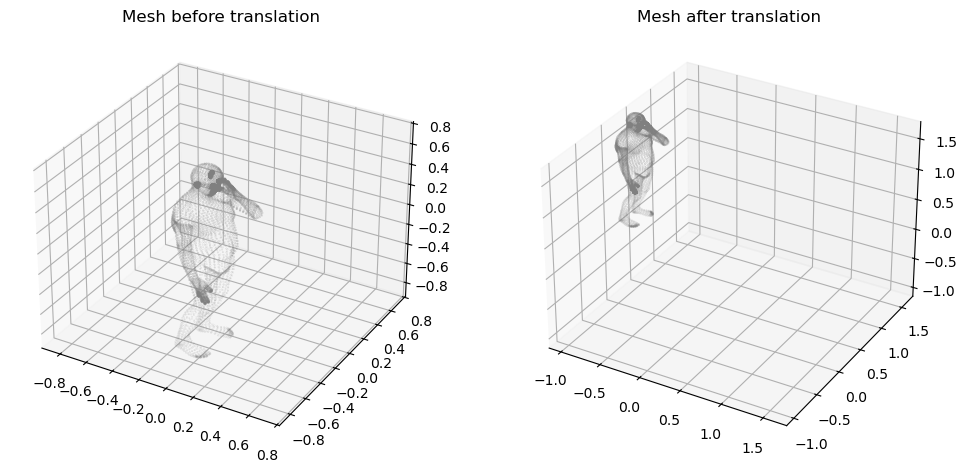

In [ ]:
# VUSU A POSE 
f = 0
visualize_frame(verts[f], trans[f])

In [ ]:
# VISU A SEQUENCE 

'''train_animation = visualize_seq(verts[::20], faces[0])
display(HTML(train_animation.to_jshtml()))'''

'train_animation = visualize_seq(verts[::20], faces[0])\ndisplay(HTML(train_animation.to_jshtml()))'

### visualize seq with translation following the data['trans'] trajectory:


In [ ]:
def visualize_seq_with_translation(verts, faces, trans):
    from matplotlib.animation import FuncAnimation
    from IPython.display import HTML
    import matplotlib.pyplot as plt

    fig = plt.figure(figsize=(12, 6))
    ax_pc = fig.add_subplot(121, projection='3d')
    ax_mesh = fig.add_subplot(122, projection='3d')

    total_frames = len(verts)

    def update_view(frame):
        ax_pc.cla()
        ax_mesh.cla()

        val_min = verts.min().cpu().item()
        val_max = verts.max().cpu().item()

        # Apply translation to the current frame
        translated_verts = verts[frame] + trans[frame]

        gt_pc = translated_verts.cpu().numpy()

        # Point cloud
        ax_pc.scatter(gt_pc[:, 0], gt_pc[:, 1], gt_pc[:, 2], s=0.01, c='gray')
        ax_pc.set_title(f"Point Cloud Frame {frame + 1}")
        ax_pc.set_xlim(val_min, val_max)
        ax_pc.set_ylim(val_min, val_max)
        ax_pc.set_zlim(val_min, val_max)
        ax_pc.view_init(elev=20, azim=50)

        # Mesh
        ax_mesh.plot_trisurf(gt_pc[:, 0], gt_pc[:, 1], gt_pc[:, 2], triangles=faces, color='green', alpha=0.2)
        ax_mesh.set_title(f"Mesh Frame {frame + 1}")
        ax_mesh.set_xlim(val_min, val_max)
        ax_mesh.set_ylim(val_min, val_max)
        ax_mesh.set_zlim(val_min, val_max)
        ax_mesh.view_init(elev=20, azim=50)

    ani = FuncAnimation(fig, update_view, frames=total_frames)
    plt.close(fig)
    return ani



In [ ]:
import matplotlib as mpl
mpl.rcParams['animation.embed_limit'] = 100  # Allow large animation
  
trans_tensor = torch.tensor(data['trans'], dtype=torch.float32).to(device)
ani = visualize_seq_with_translation(verts[::20], faces[0].cpu().numpy(), trans_tensor[::20])
HTML(ani.to_jshtml())




# 2. CODE TO READ CMU DATA 
### ATTENTION: Groupe 1, vous n'avez pas tout des codes pour creer des meshes. Donc ne pas tester des codes précédament ! Concentrer seulement sur cette partie. 
### Il faut que vous voyez avec le goupe 2 pour recuperer des données de CMU! 

### Load one sequence of CMU data 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the npz file
npz_file_path ="/mnt/c/Users/hanin/OneDrive/Bureau/PRONTO/CMU/09/09_01_poses.npz"
npz_smplx = "/mnt/c/Users/hanin/OneDrive/Bureau/PRONTO/smplx/SMPLX_MALE.npz"
npz_file = np.load(npz_file_path)#, allow_pickle=True)
npz_file_smplx = np.load(npz_smplx, allow_pickle=True)  

# Extract the data
print("Extracting data...")
data = {}
for key in npz_file.keys():
    print(f"Key: {key}")
    try : 
        if npz_file[key].shape == ():
            print(f"Content: {npz_file[key]}")
        else:
            print(f"Shape: {npz_file[key].shape}")
    except:
         
        continue
    data[key] = npz_file[key]
    print(data[key].shape)
print("Data extracted.")

Extracting data...
Key: trans
Shape: (148, 3)
(148, 3)
Key: gender
Content: male
()
Key: mocap_framerate
Content: 120.0
()
Key: betas
Shape: (16,)
(16,)
Key: dmpls
Shape: (148, 8)
(148, 8)
Key: poses
Shape: (148, 156)
(148, 156)
Data extracted.


### RECUPERER LE TRANSLATATION 

In [ ]:
trans = data['trans']
print(trans)

[[-1.55510282e+00  2.38219704e-01  9.02801579e-01]
 [-1.52739759e+00  2.38018105e-01  8.96394283e-01]
 [-1.49885000e+00  2.37881868e-01  8.90449554e-01]
 [-1.47037670e+00  2.37815155e-01  8.85440115e-01]
 [-1.44253640e+00  2.37700938e-01  8.82155990e-01]
 [-1.41451832e+00  2.37634488e-01  8.80485195e-01]
 [-1.38607032e+00  2.37747577e-01  8.79781145e-01]
 [-1.35753065e+00  2.37827790e-01  8.80010760e-01]
 [-1.32866125e+00  2.37527834e-01  8.81097083e-01]
 [-1.29869414e+00  2.37546926e-01  8.83965739e-01]
 [-1.26886470e+00  2.37671935e-01  8.87047877e-01]
 [-1.23875755e+00  2.37795273e-01  8.90960914e-01]
 [-1.20873195e+00  2.38057374e-01  8.95796919e-01]
 [-1.17908615e+00  2.38441198e-01  9.01482728e-01]
 [-1.14894929e+00  2.38663399e-01  9.07713112e-01]
 [-1.11844440e+00  2.38701708e-01  9.14367567e-01]
 [-1.08771489e+00  2.38500158e-01  9.21219684e-01]
 [-1.05587420e+00  2.38299640e-01  9.28510752e-01]
 [-1.02513200e+00  2.38190109e-01  9.35645584e-01]
 [-9.93880853e-01  2.38255391e-

### Visualiez  transation 

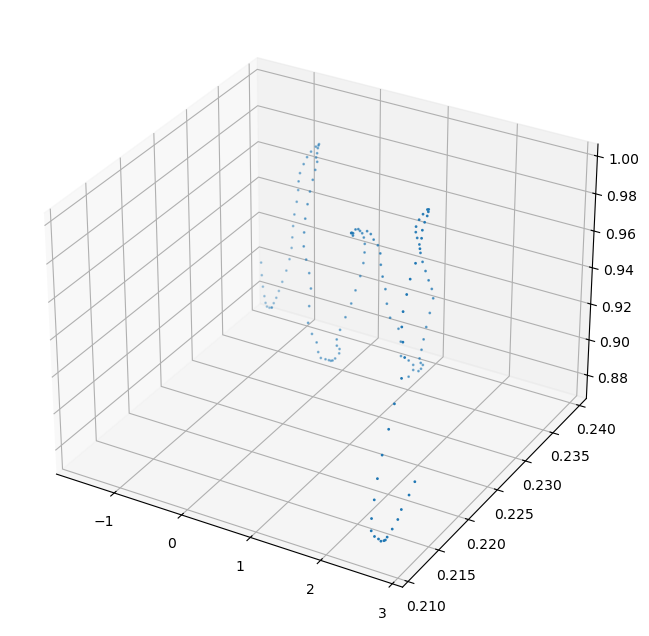

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(trans[:,0], trans[:,1], trans[:,2], s=1, label='translation')

# A VOUS DE FAIRE LE TRAVAIL ! 